![Image](./resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Population Coding</h1> 
<h2 align="center"> Day 2 Problem Sets</h2> 

<h3 align="center">Tuesday, August 22, 2023</h3> 

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #DFF0D8; ">

<h2> Morning session </h2>

1. How does decoding accuracy change for different stimulus types (e.g. natural scenes, static gratings)?

In [1]:
# import packages

import numpy as np    # used for creating and manipulating arrays

import matplotlib.pyplot as plt  # used for plotting data
%matplotlib inline

In [2]:
# create cache object

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = '/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json' 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
# load data for one session

session_id = 798911424

session = cache.get_session_data(session_id)

In [4]:
# load units table & filter for V1 units

units = session.units

units_VISp = units[units.ecephys_structure_acronym == 'VISp']

In [5]:
# load stimulus presentations

from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities

def passthrough_function(input):
    return input

naming_utilities.standardize_movie_numbers = passthrough_function
session.naming_utilities = naming_utilities # this is needed to circumvent a bug in the AllenSDK

stimulus_presentations = session.stimulus_presentations

In [6]:
# filter for natural scenes

stimulus_presentations_ns = stimulus_presentations[stimulus_presentations.stimulus_name == 'natural_scenes']

In [7]:
# extract spike counts (each trial is 250 ms long)

da = session.presentationwise_spike_counts(np.arange(0,0.25,0.01), 
                                           stimulus_presentations_ns.index.values, 
                                           units_VISp.index.values)

In [8]:
# normalize our spike count matrix

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 0.25
max_rates = firing_rates.max('unit_id')
max_rates_tiled = np.tile(max_rates, (len(units_VISp),1))
norm_firing_rates = firing_rates / max_rates_tiled 

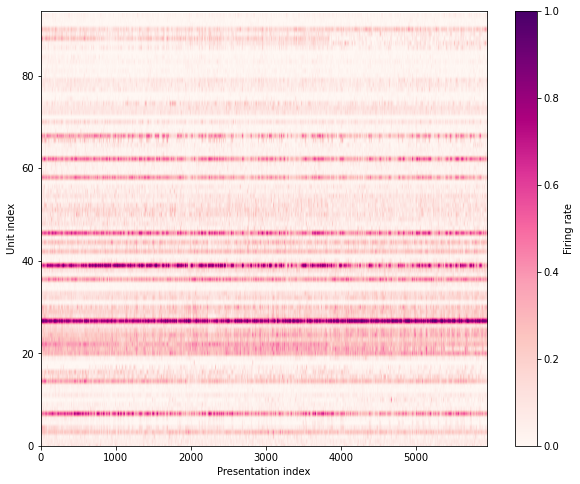

In [9]:
# plot this matrix

plt.figure(figsize=(10,8))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
plt.colorbar(label='Firing rate', aspect=20)
_ = plt.ylim([0, len(units_VISp)])

In [10]:
# prepare the data for classification

responses = norm_firing_rates.data.T

# extract the `frame` instead of the `orientation`
labels = stimulus_presentations_ns.frame.values.astype('int')

# the conditions are the unique frames
conditions = np.unique(labels)

print(f'Shape of response matrix: {responses.shape}')
print(f'Shape of labels matrix: {labels.shape}')

Shape of response matrix: (5950, 94)
Shape of labels matrix: (5950,)


In [11]:
# train an SVM

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.4890756302521009
0.49075630252100844
0.5042016806722689
0.484873949579832
0.47478991596638653

mean accuracy: 0.4887394957983194
chance: 0.008403361344537815


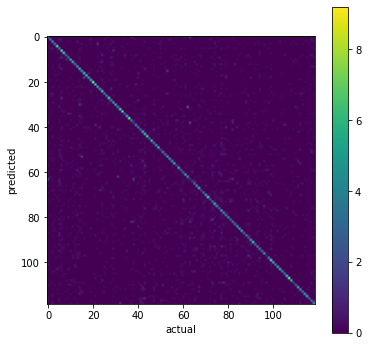

In [12]:
# plot the confusion matrix

def plot_confusion_matrix(confusions):
    
    plt.figure(figsize=(6,6))
    
    mean_confusion = np.mean(confusions, axis=0)

    plt.imshow(mean_confusion)
    plt.colorbar()

    plt.xlabel("actual")
    plt.ylabel("predicted")
    
plot_confusion_matrix(confusions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #DFF0D8; ">

2. How does decoding accuracy vary across brain regions?

In [13]:
# let's pick a non-visual region (CA1):

units_CA1 = units[units.ecephys_structure_acronym == 'CA1']

In [14]:
# extract spike counts (each trial is 250 ms long)

da = session.presentationwise_spike_counts(np.arange(0,0.25,0.01), 
                                           stimulus_presentations_ns.index.values, 
                                           units_CA1.index.values)

In [15]:
# normalize our spike count matrix

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 0.25
max_rates = firing_rates.max('unit_id')
max_rates_tiled = np.tile(max_rates, (len(units_CA1),1))
norm_firing_rates = firing_rates / max_rates_tiled 

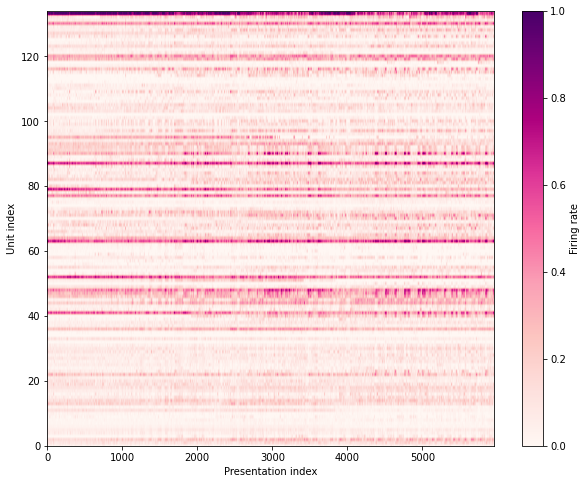

In [16]:
# plot this matrix

plt.figure(figsize=(10,8))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
plt.colorbar(label='Firing rate', aspect=20)
_ = plt.ylim([0, len(units_CA1)])

In [17]:
# prepare the data for classification

responses = norm_firing_rates.data.T

# extract the `frame` instead of the `orientation`
labels = stimulus_presentations_ns.frame.values.astype('int')

# the conditions are the unique frames
conditions = np.unique(labels)

print(f'Shape of response matrix: {responses.shape}')
print(f'Shape of labels matrix: {labels.shape}')

Shape of response matrix: (5950, 134)
Shape of labels matrix: (5950,)


In [18]:
# train an SVM

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.019327731092437017
0.013445378151260456
0.01092436974789912
0.01764705882352946
0.010084033613445342

mean accuracy: 0.01428571428571428
chance: 0.008403361344537815


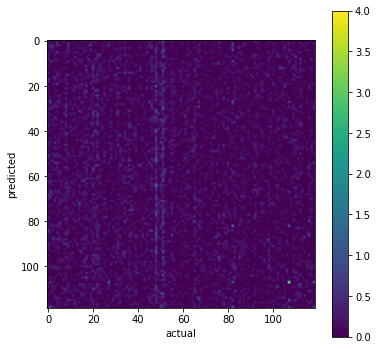

In [19]:
# plot the confusion matrix

def plot_confusion_matrix(confusions):
    
    plt.figure(figsize=(6,6))
    
    mean_confusion = np.mean(confusions, axis=0)

    plt.imshow(mean_confusion)
    plt.colorbar()

    plt.xlabel("actual")
    plt.ylabel("predicted")
    
plot_confusion_matrix(confusions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #DFF0D8; ">

3. What is the minimum amount of time within a trial needed to achieve high decoding performance?

In [20]:
# let's go back to drifting gratings, because each stimulus is longer

stimulus_presentations_dg = stimulus_presentations[stimulus_presentations.stimulus_name == 'drifting_gratings']

In [21]:
# filter for one orientation

presentations = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == 2.0)]

presentations = presentations.sort_values(by='orientation')

In [22]:
# extract the population response

import warnings  
warnings.filterwarnings("ignore") # ignore warnings for the rest of this tutorial

da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), 
                                           presentations.index.values, 
                                           units_VISp.index.values)

In [23]:
# create firing rate matrices for different time spans

durations = np.arange(0.05,1,0.05) # increase duration in 50 ms increments

norm_firing_rates = []

for duration in durations:

    subset = da.sel(time_relative_to_stimulus_onset=slice(0,duration))
    firing_rates = subset.sum('time_relative_to_stimulus_onset').T / duration
    
    max_rates = firing_rates.max('unit_id') + 0.01 # avoid dividing by 0
    max_rates_tiled = np.tile(max_rates, (len(units_VISp),1))
    norm_firing_rates.append(firing_rates / max_rates_tiled)

In [24]:
# now run the classifier for each duration

# we're trying to predict the orientation of each trial
labels = presentations.orientation.values.astype('int')

# the conditions are the unique orientations
conditions = np.unique(labels)

# total number of splits for training
num_splits = 10

# create an array to store our accuracies:
accuracies = np.zeros((len(durations), num_splits))

for ind1, norm_firing_rate in enumerate(norm_firing_rates):
    
     # retrieve the underlying numpy array and transpose it
    responses = norm_firing_rate.data.T
    
    ind2 = 0

    for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):

        clf = svm.SVC(gamma="scale", kernel="linear")
        clf.fit(responses[train_indices], labels[train_indices])

        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])

        accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)

        accuracies[ind1, ind2] = accuracy

        ind2 += 1

Text(0, 0.5, 'Mean accuracy')

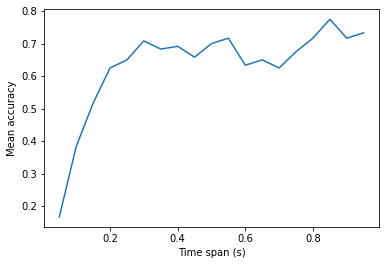

In [25]:
# and plot the results

plt.plot(durations, np.mean(accuracies, 1))
plt.xlabel('Time span (s)')
plt.ylabel('Mean accuracy')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #DFF0D8; ">

4. How does decoding performance change with behavioral state (e.g. running vs. stationary)?

In [26]:
# load running speed

running_speed = session.running_speed

running_speed.head()

,start_time,end_time,velocity
0,24.82399,24.83961,-1.060405
1,24.83961,24.85607,0.827345
2,24.87287,24.88942,-2.572146
3,24.88942,24.90628,3.667684
4,24.92289,24.93947,0.259265


Text(0, 0.5, 'Running speed (cm/s)')

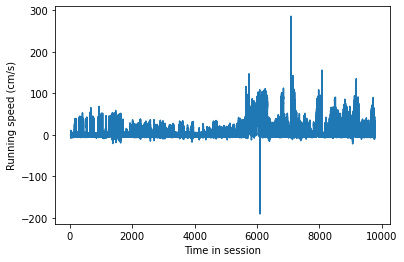

In [27]:
# plot it for this session

plt.plot(running_speed.start_time.values, running_speed.velocity.values)
plt.xlabel('Time in session')
plt.ylabel('Running speed (cm/s)')

Text(0, 0.5, 'Count')

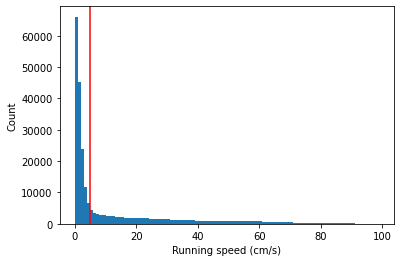

In [28]:
# plot a histogram of speeds, showing a threshold of 5 cm/s

plt.hist(running_speed.velocity.values, bins=np.arange(0,100))
plt.axvline(5, color='r')
plt.xlabel('Running speed (cm/s)')
plt.ylabel('Count')

In [29]:
# calculate the running speed for each natural scenes trial

speed_for_trial = []

for idx in range(len(stimulus_presentations_ns)):

    subset = running_speed[(running_speed.start_time >= stimulus_presentations_ns.iloc[idx].start_time) &
                           (running_speed.end_time < stimulus_presentations_ns.iloc[idx].stop_time)]

    speed_for_trial.append(subset.velocity.mean())

Text(0, 0.5, 'Count')

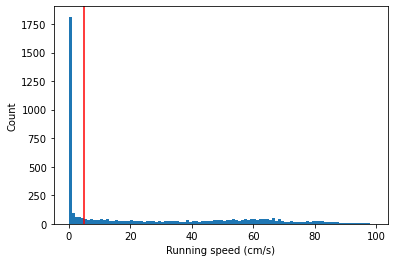

In [30]:
# plot a histogram of speeds, showing a threshold of 5 cm/s

plt.hist(speed_for_trial, bins=np.arange(0,100))
plt.axvline(5, color='r')
plt.xlabel('Running speed (cm/s)')
plt.ylabel('Count')

In [31]:
# find the trials where the mouse is running

running_trials = np.array(speed_for_trial) > 5
stationary_trials = np.array(speed_for_trial) <= 5

np.sum(running_trials) / len(stimulus_presentations_ns) # determine fraction running

0.39243697478991596

In [32]:
# extract spike counts (each trial is 250 ms long)

da = session.presentationwise_spike_counts(np.arange(0,0.25,0.01), 
                                           stimulus_presentations_ns.index.values, 
                                           units_VISp.index.values)

In [33]:
# normalize our spike count matrix

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 0.25
max_rates = firing_rates.max('unit_id')
max_rates_tiled = np.tile(max_rates, (len(units_VISp),1))
norm_firing_rates = firing_rates / max_rates_tiled 

In [34]:
# prepare the data for classification

responses = norm_firing_rates.data.T
responses_run = responses[running_trials,:]
responses_stationary = responses[stationary_trials,:]

# extract the `frame` instead of the `orientation`
labels = stimulus_presentations_ns.frame.values.astype('int')
labels_run = labels[running_trials]
labels_stationary = labels[stationary_trials]

# the conditions are the unique frames
conditions = np.unique(labels)

In [35]:
# train an SVM on the running trials

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

responses = responses_run
labels = labels_run

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.6531049250535332
0.6359743040685225
0.6359743040685225
0.6702355460385439
0.6102783725910064

mean accuracy: 0.6411134903640257
chance: 0.008403361344537815


In [36]:
# train an SVM on the stationary trials
responses = responses_stationary
labels = labels_stationary

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.363762102351314
0.35131396957123096
0.35961272475795303
0.3526970954356846
0.3526970954356846

mean accuracy: 0.3560165975103735
chance: 0.008403361344537815


<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #DFF0D8; ">

5. Try to estimate the contribution of individual neurons to the population decoding accuracy. One way to do this would be to compute the decoding accuracy with all neurons except one, and examine how this changes decoding accuracy.

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

<h2> Afternoon session </h2>

1. Study the dimensionality of the trial shuffled population activities. How much of the low-dimensionality can be attributed to signal correlations vs noise correlations?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

2. How is decoding of different stimulus attributes affected by noise correlation? (e.g., natural scenes, etc.)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

3. How much does the dependence of decoding on noise correlations vary between brain regions?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

4. How are noise correlations affected by behavioral state? E.g., how much of that correlation is driven by neurons responding similarly to global behavioral changes, vs other variables?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

5. How much do the signal and noise correlations vary between brain regions?